# DAT200 CA4 2022

Kaggle username: dinussen27

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer as SI
from sklearn.preprocessing import OneHotEncoder 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer as II
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.linear_model  import LogisticRegression
from sklearn.utils.fixes import loguniform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from numpy import interp

### Reading data

In [2]:
df = pd.read_csv('train.csv', index_col=0)
df = pd.get_dummies(df, drop_first = True)
#print(df.head())
X_test_final = pd.read_csv('test.csv', index_col=0)
X_test_final = pd.get_dummies(X_test_final, drop_first = True)
#print(X_test_final.head())


### Data exploration and visualisation

Rooms                                    0
Distance                                 0
Postcode                                 0
Bedrooms                                 0
Bathroom                                 0
Car                                      0
Landsize                                 0
YearBuilt                                0
Lattitude                                0
Longtitude                               0
Propertycount                            0
Price class                              0
Type_t                                   0
Type_u                                   0
Method_S                                 0
Method_SA                                0
Method_SP                                0
Method_VB                                0
Regionname_Eastern Victoria              0
Regionname_Northern Metropolitan         0
Regionname_Northern Victoria             0
Regionname_South-Eastern Metropolitan    0
Regionname_Southern Metropolitan         0
Regionname_

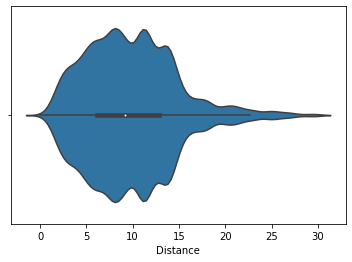

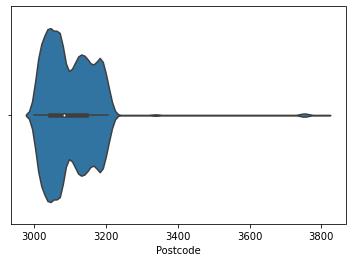

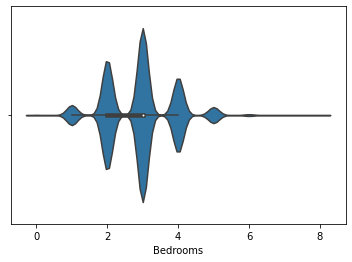

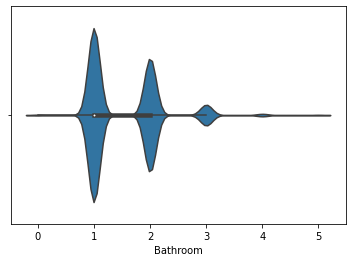

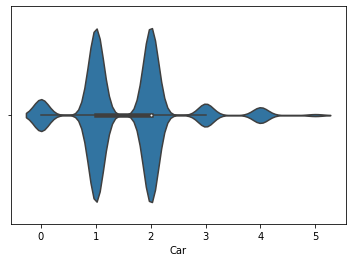

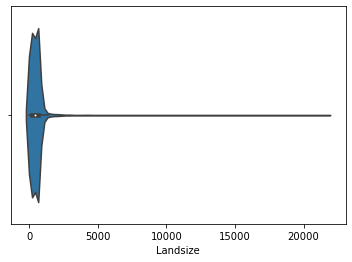

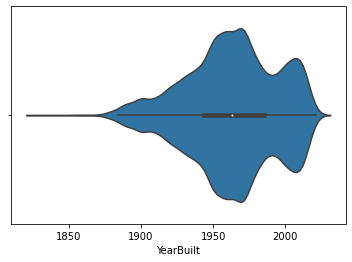

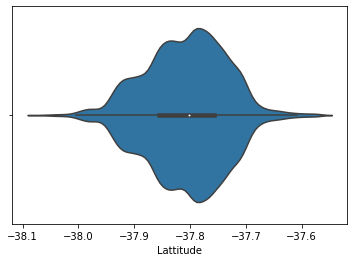

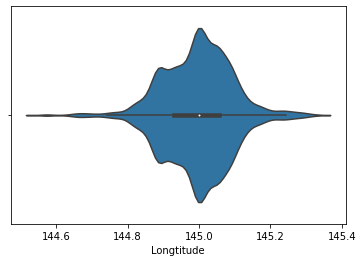

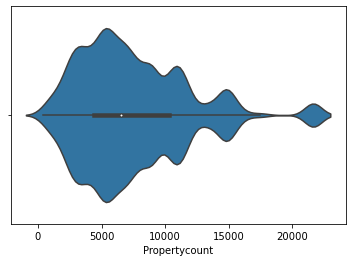

--------------------------------------------------
TEST
--------------------------------------------------


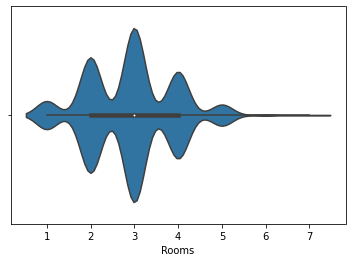

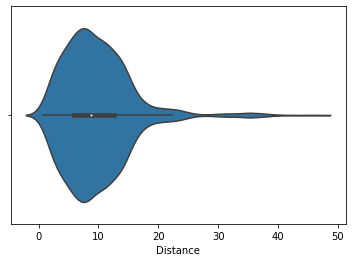

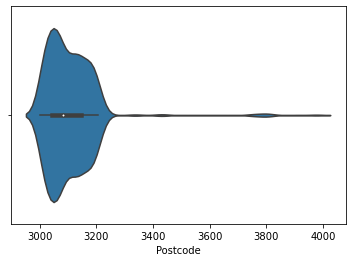

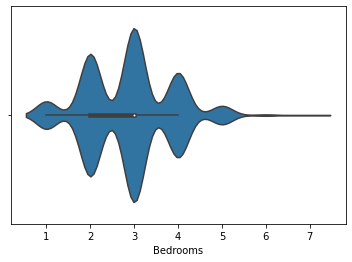

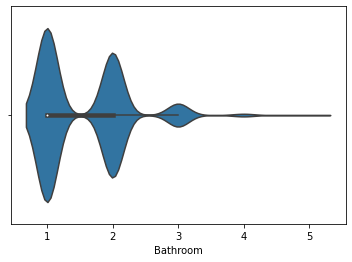

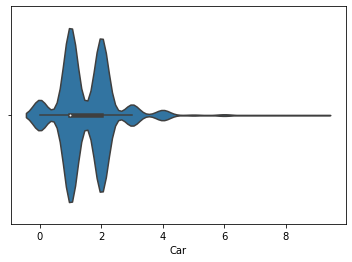

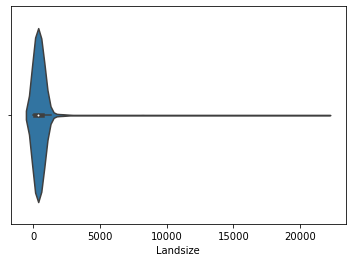

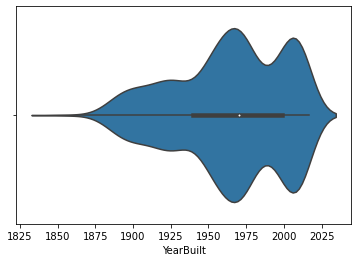

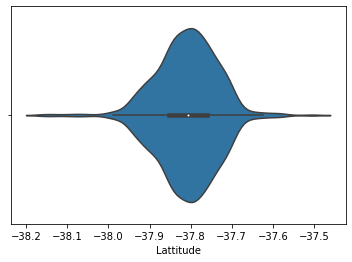

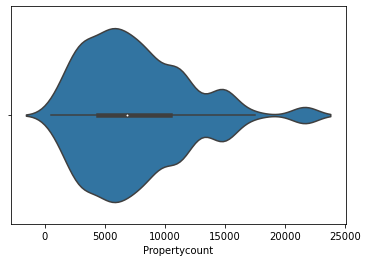

In [16]:
print(df.isnull().sum())
df=df.dropna(subset =['Car'])
df=df.dropna(subset =['Bathroom'])
df=df.dropna(subset =['Landsize'])
df=df.dropna(subset =['Propertycount'])  
print('*'*5)
print(df.isnull().sum())

imr = II(missing_values=np.nan, initial_strategy='median')
imr = imr.fit(df.values)
df = pd.DataFrame(imr.transform(df.values), columns = df.columns)
print(df.isnull().sum())

for col in df.columns[:11]:
    sns.violinplot(x=df[col])
    plt.show()
print('-'*50)
print('TEST')
print('-'*50)
for name in X_test_final.columns[:11]:
    sns.violinplot(x=X_test_final[name])
    plt.show()
df_roc = df.copy()

### Data cleaning

In [4]:
#the intervals are based on testdata

df = df[df['YearBuilt'].between(1700, 2022)]
df = df[df['Rooms'].between(0, 8)]
df = df[df['Distance'].between(0, 30)]
df = df[df['Bedrooms'].between(0, 8)]
df = df[df['Bathroom'].between(0, 5)]
df = df[df['Car'].between(0, 5)]
df = df[df['Landsize'].between(0, 25000)]
df = df[df['Propertycount'].between(0, 25000)]

y = df['Price class']
X = df.drop(columns=['Price class'])

### Data exploration after cleaning

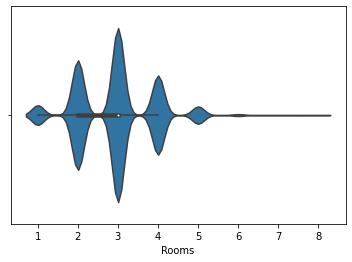

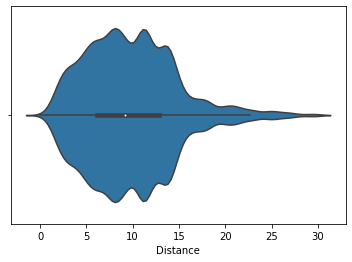

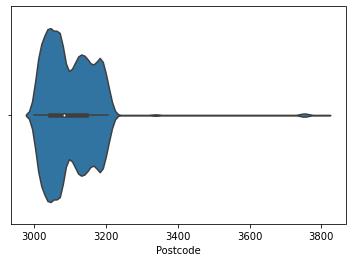

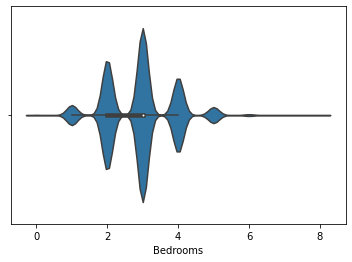

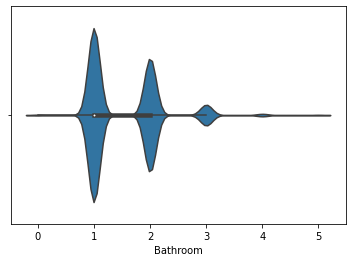

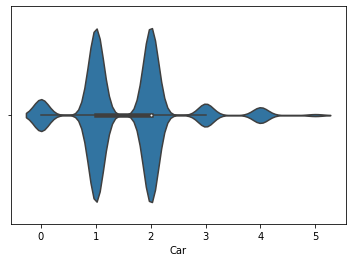

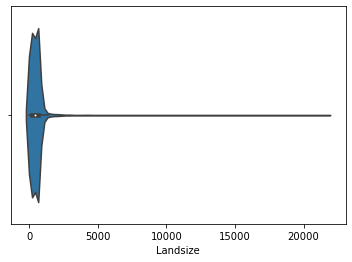

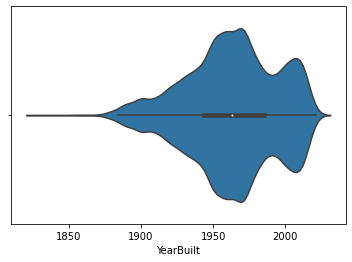

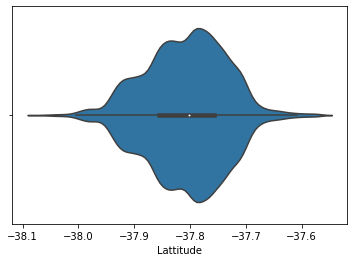

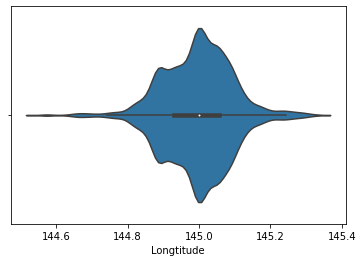

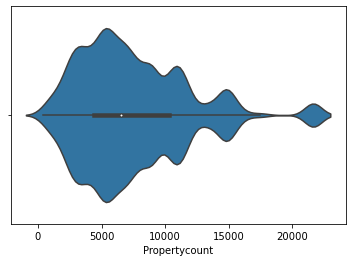

(11113, 25)


In [5]:
for col in df.columns[:11]:
    sns.violinplot(x=df[col])
    plt.show()
    
print(df.shape)

### Data preprocessing

#### Train test split

In [6]:
[X_train, X_test, y_train, y_test] = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

#### Scaling

### Modelling

#### Data pipeline with kernel

In [7]:
pipe_svc = make_pipeline(StandardScaler(),PCA(), SVC(random_state=1))
pipe_svc.get_params()
param_range  = [10,100,400,500,700,1000,2000] # For regularization parameter C.
param_range2 = [0.001,0.01, 0.1,1,10]         # For scaling parameter gamma og rbf-kernel.

param_grid   = [
                {'svc__C': param_range, 'svc__gamma': param_range2, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)





0.7698894246367686
{'svc__C': 500, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


Test accuracy: 0.859
Test accuracy: 0.781
[[1265  113    0]
 [ 132  558   17]
 [   2   80   56]]


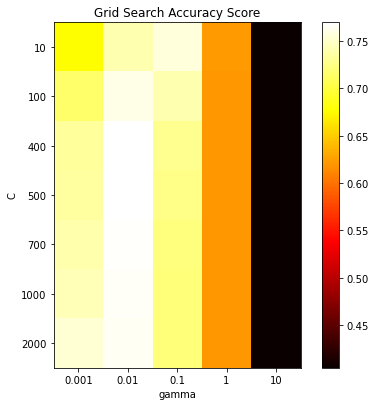

In [8]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))
# ... or:
#gs.decision_function(X_train) # (tedious)
print('Test accuracy: %.3f' % gs.score(X_test, y_test))

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

scores = gs.cv_results_['mean_test_score'].reshape(len(param_range),len(param_range2))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma') # 1/(softness of decision boundary), i.e. small = soft
plt.ylabel('C')     # 1/(size of support vector margin), i.e. large = tight margin
plt.colorbar()
plt.xticks(np.arange(len(param_range2)), param_range2)
plt.yticks(np.arange(len(param_range)), param_range)
plt.title('Grid Search Accuracy Score')
plt.show()

sc = StandardScaler()
sc.fit(X)
X_test_final_std = sc.transform(X_test_final)

target = gs.predict(X_test_final)
target = target.astype(int)
y_df = pd.DataFrame()
y_df['Price class'] = target
y_df.to_csv('results_AD.csv')




#### Data pipeline with regularization

In [9]:

# Simple trainig data pipeline
pipe_lr = make_pipeline(StandardScaler(),    # Scaling of input features
                        PCA(), # Compression into principal components
                        LogisticRegression(random_state=1, penalty = 'l2')) # Fit Logistic Regression with standard parameters
pipe_lr.get_params()
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_range2 = ['newton-cg', 'lbfgs', 'sag', 'liblinear' ]

param_grid_lr   = [
    {'logisticregression__solver': param_range2, 'logisticregression__C': param_range}
                  ]
gs_lr = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid_lr, 
                  scoring='f1_macro', 
                  cv=5,
                  n_jobs=-1)


0.7042304233479834
{'logisticregression__C': 1.0, 'logisticregression__solver': 'newton-cg'}
Test accuracy: 0.816
Test accuracy: 0.691
[[1251  125    2]
 [ 165  514   28]
 [   3   85   50]]


C:\Users\dinus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


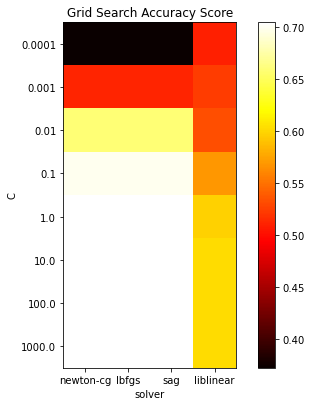

In [10]:
gs_lr = gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_)
print(gs_lr.best_params_)

clf_lr = gs_lr.best_estimator_
clf_lr.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf_lr.score(X_test, y_test))
# ... or:
#gs.decision_function(X_train) # (tedious)
print('Test accuracy: %.3f' % gs_lr.score(X_test, y_test))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat_lr = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat_lr)

scores = gs_lr.cv_results_['mean_test_score'].reshape(len(param_range),len(param_range2))


plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('solver') 
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_range2)), param_range2)
plt.yticks(np.arange(len(param_range)), param_range)
plt.title('Grid Search Accuracy Score')
plt.show()

#### Other models used for Kaggle submission

### Final Evaluation and confusion matrix

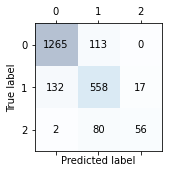

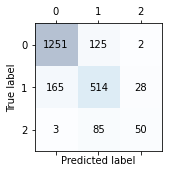

In [11]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_lr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_lr.shape[0]):
    for j in range(confmat_lr.shape[1]):
        ax.text(x=j, y=i, s=confmat_lr[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

### Kaggle submission

In [18]:
target = gs.predict(X_test_final)
target = target.astype(int)
y_df = pd.DataFrame()
y_df['Price class'] = target
y_df.to_csv('results_AD.csv')

#### ROC Curve for binary classificaion problem

8550    1.0
8996    1.0
9605    1.0
4099    1.0
8217    1.0
       ... 
6668    2.0
3085    2.0
6660    1.0
5547    2.0
8537    1.0
Name: Price class, Length: 3380, dtype: float64
[ 603  608  635 ... 3377 3378 3379]
[   0    1    2 ... 3377 3378 3379]
[   0    1    2 ... 3377 3378 3379]
[   0    1    2 ... 3377 3378 3379]
[   0    1    2 ... 2785 2786 2792]


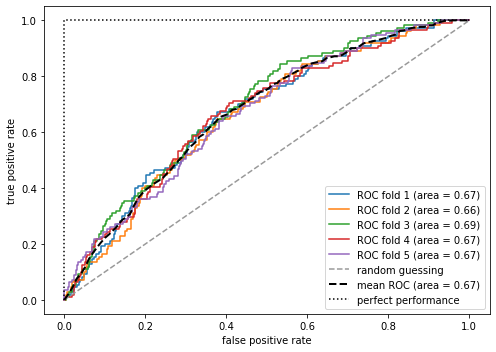

In [17]:
#print(df_roc.head(4))
df_roc = df_roc[df_roc['Price class'].between(1, 2)]
#print(df_roc['Price class'])
y_roc = df_roc['Price class']
X_roc = df_roc.drop(columns=['Price class'])

[X_train_roc, X_test_roc, y_train_roc, y_test_roc] = train_test_split(X_roc, y_roc, test_size=0.20,
                                                                      stratify=y_roc, random_state=1)

pipe_lr_roc = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=100.0,
                                           solver='lbfgs'))

cv = list(StratifiedKFold(n_splits=5).split(X_train_roc, y_train_roc))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
print(y_train_roc)
# Loop through folds of CV
for i, (train, test) in enumerate(cv):
    print(train)
    probas = pipe_lr_roc.fit(X_train_roc.values[train],
                             y_train_roc.values[train]).predict_proba(X_train_roc.values[test]) # Predict probability of classes

    # False Positive and True Positive Rates (thresholds for the decision function)
    fpr, tpr, thresholds = roc_curve(y_train_roc.values[test],
                                     probas[:, 1],
                                     pos_label=2)
    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
# Average AUC
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()